# VIX Forecast-Based Volatility Trading with Asset Diversification

Sean Lin, Thomas McDonnell, Benjamin Panovich, Madison Rusch

In [2]:
import os 
import pandas as pd 
import numpy as np
import wrds 

import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import data_collection 
import model_building
import trading_strategy

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# KEY = os.getenv('QUANDL_KEY') # If you want to download Quandl data, put your own key here
KEY = 'uoxc6V3s61czWuHoGLcs'
# conn = wrds.Connection(wrds_username='seanl59') # Similarly, if you want to download WRDS data, put your username here
conn = 1

***

## 1. Introduction

This notebook presents a quantitative trading strategy focused on trading volatility using VIX forecasts. Volatility is a measure of uncertainty in the markets (or variance) and VIX, CBOE's volatility index, is a popular index that measures the market's forward expectation of volatility. While high volatility can be viewed in a negative light, it can create trading opportunities. Increased volatility means increased fear in the markets, resulting in cashflow leaving equities and entering other asset classes, like fixed income, commodities, or currencies. Though equities outperform over long-periods of time, these other asset classes can outperform in moments of heightened volatility. Equity options are another asset that can be linked to volatility. In many cases, options are used to hedge our directional-risk or to even take levered directional risks, they can also be used to play volatility. Increased volatility results in higher option prices as higher volatility increases the probability that the option expires in-the-money (with value). Consequently, an option can increase in value even if the direction is wrong provided that the implied volatility is increasing quick enough. The strategy aims to capitalize on these opportunities by trading a combination of different asset classes. 

The paper is divided into three main sections. The first section focuses on predicting VIX using a time-series ARIMA(1,1,1) model. The section explores predictors and explains why they were chosen, along with an evaluation of the model's performance. The second section examines the tradeable assets that are used to implement the strategy, incorporating leverage and transaction costs; a backtest of the strategy is also presented. The third section discusses limitations of the strategy and future steps.

The objective of this notebook is to present a starting point for trading volatility. While profitability of the strategy is not the main focus, the results of the backtest show potential for quantitative strategies in this realm and serves as a starting point for future research into more profitable volatility-related trading strategies.

***

## 2. Building the Model

This section presents the ARIMA(1,1,1) model used for forecasting VIX. The inspiration for this model comes from Ahoniemi's 2006 paper, which demonstrated that ARIMA(1,1,1) models were the best linear models for forecasting VIX. A similar model is presented in this notebook, which uses SPY returns, MSCI EAFE (ex-US developed market) returns, SPY volume change, and economic calendar events as regressors.

The rationale for these regressors is as follows:
- SPY returns typically have large negative correlation with VIX returns. When SPY has a large negative day, it is likely that VIX is positive.
- MSCI EAFE returns do not include US markets and may have lower correlation. However, they provide information from other parts of the world, which can add to the model.
- Days with large SPY volume can be significant. This can indicate that investors are leaving equities. For example, during the Russian invasion of Ukraine, there was an extremely high amount of volume.
- Days with economic calendar events can be more volatile. These events can include FOMC or CPI events. For example, as of lately, CPI events can cause SPX to have 100 point moves in minutes. This phenomenon can also be seen with non-economic calendar events, like earnings. A common strategy is to buy option straddles for a company releasing earnings (i.e NFLX and META during certain 2022 earnings reports).

In this model, a rolling-window of 126 days is used to forecast the next-day-out. Afterward, the rolling window is shifted to include the most recent day and the process is repeated. To remove forward-looking bias, SPY volume and SPY/EAFE returns are lagged. This is a noteable difference from Ahoniemi's paper, where EAFE returns are contemporaneous with SPX returns as they trade at the trading day open and predict the end-of-day return. Here, the next day's VIX returns are predicted. This is due to the unavailability of bid and offers of options at the open.

Here, the class `DataCollection` is used to obtain data for various equities and future contracts using the *Quandl* database. In addition, certain data is download from other websites (i.e investing.com and marketwatch.com). This includes VIX data or economic calendar data. Raw data is also presented in the */data/* folder (i.e economic calendar, EAFE, VIX).

In [4]:
START_DATE, END_DATE = '2014-01-01', '2021-12-31' 
YEARS = ['2014','2015','2016','2017','2018','2019','2020','2021','2022']
MONTH_CODES = ['H','M','U','Z']
DataCollection = data_collection.DataCollection(KEY,START_DATE,END_DATE,YEARS,MONTH_CODES) # Class used for data collection

In [5]:
vix_data = pd.read_csv('./data/vix_data.csv',index_col=0,parse_dates=True) # VIX data, obtained from investing.com
raw_calendar_data = pd.read_csv('./data/calendar_raw.csv',index_col=0,parse_dates=True) # Raw economic calendar data, obtained from marketwatch.com
eafe_data = pd.read_csv('./data/eafe_data.csv',index_col=0,parse_dates=True) # EAFE data, obtained from investing.com
spy_data = DataCollection.fetch_quandl_table('QUOTEMEDIA/PRICES','SPY')

calendar_data = DataCollection.convert_calendar(raw_calendar_data,vix_data) # Converting raw calendar data to processed data 
predictors = pd.concat([vix_data,eafe_data,spy_data,calendar_data],axis=1)

predictors['VIX Returns'] = predictors['VIX'].pct_change().shift(-1) # Shifting the data
predictors['SPY Returns'] = predictors['close'].pct_change() 
predictors['EAFE Returns'] = predictors['EAFE'].pct_change()
predictors['Days until Event'] = predictors['Days until Event'].shift(-1)
predictors['Volume Change'] = predictors['volume'].pct_change()
predictors = predictors[['VIX Returns','SPY Returns','EAFE Returns','Days until Event','Volume Change']].dropna()

The `model_building` class is used to construct the ARIMA(1,1,1) model using a rolling-window size of 126 (correpsonding to 1/2 a year in trading days) to forecast future values of VIX returns.

An ARIMA model, or an auto-regressive integrated moving average model is a time-series model used to forecast future values of a variable (in this case, VIX returns) based on past values. It is composed of three components: p, d, and q, which correspond to the autoregressive, integrated, and moving average components respectively.

The autoregressive component (p) models the linear relationship between VIX returns and its past values assuming that the current value is a linear combination of the previous values. The parameter p indicates the number of lagged values that are used to forecast the future value.

The integrated component (d) accounts for any non-stationarity present in the data. It differences the time-series with a lag of d in order to make it stationary. 

The moving average component (q) models the noise (or error terms) in the data as a linear combination of previous values. In other words, it is the number of lagged values of the error term to predict future values. 

In this notebook, a (1,1,1) ARIMA model is used.

In [6]:
Model = model_building.Model(predictors,126)
Model.train_model()

100%|██████████| 1887/1887 [04:20<00:00,  7.25it/s]


When evaluating these models, it's important to look at the p-values of the regressor coefficients. A low p-value (usually < 0.05) indicates that the coefficients are significant and meaningful. A high p-value (> 0.05) means that the coefficients may not be significant. Here, we can see that there are periods where the coefficients are significant and periods where the coefficients are not significant. This means that results from these periods should be viewed with caution. It is important to remember that the p-value is not the probability of the coefficient being significant. The p-value is a result of standardizing the T-statistics when forming the hypothesis tests and corresponding confidence intervals.

In [7]:
Model.plot_pvalues()

Some observations:
- We see that the MA component is almost always significant compared to the other predictors. It is not as significant towards the end of the sample.
- The AR component appears to be the most significant towards the end of 2015. 
- The EAFE returns appears to be the least significant out of all the predictors. It doesn't have a whole period where it's significant like the other predictors.

Let's quantify this a bit more: let's look at the proportions of time in which each predictor is significant.

In [8]:
Model.calc_significance().T

,SPY Returns,EAFE Returns,Days until Event,Volume Change,AR,MA
Proportion,0.104399,0.068892,0.103869,0.059883,0.122946,0.839958


We can see that the MA component has the highest proportion of being significant, followed by the AR component, and then economic calendar. This is in line with what we qualitatively observed.

Now, let's look at the betas. We will *ignore* the fact that some of the betas aren't always significant. It should be remembered that this is a valid (and very important!) concern. For the highest statistical confidence, the coefficients should be significant: this will be touched on later. When looking at the betas, we are primarily looking at the signs. The betas can give an expected change in VIX returns with a change in a certain predictor. For example, in univariate linear regression, if we are regressing *price of house* on *square feet* and we obtain the following equation $ \text{Price of House} = 500 (\text{Square Feet}) + 2 $ (a potentially unrealistic equation), this would mean that for every 1 increase in square feet, we would expect the price of the house to increase by $500.

In [9]:
Model.plot_betas()

We see that the betas are always negative for the MA component while they tend to vary for the other components. From these results, we can see why it is important for significant coefficients. These confidence intervals could include 0, meaning that the coefficient is 0 and actually has no effect on the VIX returns. This is why we will ignore this and continue with the analysis. We do note that the betas for the EAFE returns have a significant proportion of time being negative. A negative beta means that VIX returns will increase when the predictor decreases. This is in-line with what was observed in Ahoniemi (2006), Flemings et. al (1995) and Simons (2003). This is reasoned by the fact that "a negative coefficient leads to a drop in VIX if the returns in foreign markets have been positive and vice versa for negative returns". On the contrary, we see mostly positive betas for SPY (which is also seen in the paper). This can be attributed to positive SPY returns causing VIX to fall during day T, so in day T+1, VIX will raise as it is mean reverting.

Let's show that VIX is mean-reverting with the Augmented Dickey-Fuller test. We will first provide a visual.

In [10]:
fig = make_subplots(rows=1,cols=1,subplot_titles=("VIX",))
fig.add_trace(go.Scatter(x=vix_data.index,name="VIX",y=vix_data['VIX']),row=1,col=1)
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')
fig.update_layout(margin=dict(t=25, l=25, b=25))

In [11]:
print('AdFuller p-value: ' + str(np.round(adfuller(vix_data)[1],5)))

AdFuller p-value: 5e-05


From the ADF test, we can see that the p-value is very small, indicaing that VIX is mean-reverting. It is also good to note that this is the entire-sample (and we are trading on this). However, this does not affect any of our decisions. Now, let's look at some performance metrics for the ARIMA(1,1,1) model.

There will be two main metrics: mean-squared error (MSE) and directional accuracy. We define MSE to as the squared difference between the prediction and the true result. Directional accuracy is the percentage of time where the prediction and the true value have the same sign. The same sign is important as it indicates whether the model is predicting the direction of VIX correctly. We also include two other metrics derived from the directional accuracy: up and down accuracy. These are the accuracies conditional on the prediction being above a certain threshold. We also note the number of predictions, or the number of trades that can be realized throughout this period.

It is important to understand how up and down accuracy are calculated. These are the accuracies conditional on the predicted value being above some threshold. To be precise, these thresholds are generated from a rolling-quantile of true values. In other words, a rolling 75th and 25th quantile are calculated from the last 125 trading days. This is then marked as the threshold for significant "VIX increase" predictions and signficant "VIX decrease predictions" respectively. Here, we choose the rolling quantiles to be 0.75 and 0.25 arbitrarily. However, these values can be chosen to be anything in between 0 and 1. For simplicity, we use the 125 days such that we start our sample in 2015. We could use the true values from the first half of 2014 but this ensures that we have uniform yearly results.

It is also important to note that this mechanism may not work for other ARIMA models with different parameters. For example, a (0,0,1) model will have predictions values that are quite small and may not ever reach the true value. In that case, it may be better to utilize the rolling quantiles of the predicted values. The (1,1,1) model does not have this issue and thus we use the true values as the basis for the rolling quantile.

In [12]:
Model.performance_metrics(0.75,0.25)
Model.metrics

,MSE,DA,Up Acc,Down Acc,Prediction Num
Metrics,0.009255,0.478007,0.524272,0.625,135


We can see that the directional accuracy is less than 50%, meaning that we are correct on the directional accuracy less than half the time. This may seem discouraging. However, we note that the up-accuracy and down-accuracy are greater than 50% when we only consider predictions above and below a certain threshold. This is commonly done for these types of models as it helps filter out the noise, especially in environments where the signal-to-noise ratio is so low. 

Let's make the idea of the thresholds more precise. We will plot the predictions and true values of VIX along with the rolling thresholds for the first half of 2020. The rolling thresholds are shifted using the previous 125 days to prevent any forward-looking bias (though even if it was present, it wouldn't cause a significant change).

In [13]:
Model.plot_predictions('2020-01-01','2020-06-01')

From this sample, we see the true value of VIX in red and the predicted value in blue. We see that we enter a trade everytime the predicted value goes above the upper threshold or below the lower threshold. The idea of trading based on the ARIMA model will be made precise in the next section.

***

## 3. Trading Strategy

Now that the model has been solidified, we can now move onto forming the trading strategy associated with the VIX forecasting model. As mentioned earlier, there are several different assets one can consider when thinking about volatility: commodities, fixed income, currencies, and options. Here, we will focus on commodities, fixed income, and options. Before we delve into these assets, let's discuss the trading strategy.

As shown in the previous section, the ARIMA model gives one-day-out forecasted VIX returns. We also saw that on it's own, the directional accuracy was less than 50%. However, if we restricted the thresholds at which it activates, the accuracy increases. Using a 75% and 25% rolling quantile of actual values, the up-accuracy is around 52% while the down-accuracy is 62.5%, totaling 130 trades over 6 years. This gives us the capability of betting on volatility to increase as well as betting on volatility to decrease. In other words, we can buy assets with positive correlations and short assets with negative correlations to VIX when the model predicts high returns and then vice versa when the model predicts volatility to decrease. This will be the approach that we use: we will find assets that are correlated to VIX and trade a portfolio of them. Since the ARIMA only predicts one-day-out, we will only hold our positions for one day at a time. This allows us to actually capitalize on the model. It wouldn't make sense to predict one-day-out forecasts and hold for more than one day. 

There would be a tremendous amount of lookahead bias if we looked at the entire sample for correlations and then determined assets based on that. Instead, we will only look at 2014 (as we are not trading during this period) to determine the assets we will use from 2015-2021. In real scenarios, with trading *portfolios*, it may be better to update assets over time as certain assets may become more or less correlated.

First, let's look at future contracts. We'll first make a new DataCollection objecjt with only the year 2014.

In [14]:
START_DATE, END_DATE = '2014-01-01', '2014-12-31' 
YEARS = ['2014','2015']
MONTH_CODES = ['H','M','U','Z']
DataCollection2014 = data_collection.DataCollection(KEY,START_DATE,END_DATE,YEARS,MONTH_CODES) 

For futures, we will look at the following futures: GC, SI, NG, RB, LC, W, CL, C. For the most part, these were arbitrarily chosen. However, from *Jubinski, Lipton 2013*, it's seen that silver, gold, and oil all react in some manner to volatility. These will be the main focus of this correlation analysis.

In [15]:
gc_data = DataCollection2014.get_contract('CMX_GC_GC')
si_data = DataCollection2014.get_contract('CMX_SI_SI')
ng_data = DataCollection2014.get_contract('NYM_NG_NG')
rb_data = DataCollection2014.get_contract('NYM_RB_RB')
lc_data = DataCollection2014.get_contract('CME_LC_LC')
w_data = DataCollection2014.get_contract('CBT_W_W')
cl_data = DataCollection2014.get_contract('NYM_CL_CL')
c_data = DataCollection2014.get_contract('CBT_C_C')

In [16]:
futures = pd.concat([gc_data,si_data,ng_data,rb_data,lc_data,w_data,cl_data,c_data],axis=1)
futures.columns = ['GC','SI','NG','RB','LC','W','CL','C']
futures = futures.loc[futures.index.isin(vix_data.loc[START_DATE:END_DATE].index)]
futures = futures.pct_change().dropna()

In [17]:
correlations_to_vix = pd.DataFrame(columns=['Unconditional Correlation to VIX','Conditional Correlation to VIX'])
for column in futures.columns.values:
    vix_returns = vix_data.loc[START_DATE:END_DATE].pct_change().dropna()['VIX']
    correlations_to_vix.loc[column,'Unconditional Correlation to VIX'] = (futures[column]).corr(vix_returns)
    correlations_to_vix.loc[column,'Conditional Correlation to VIX'] = (futures[column]).corr(vix_returns[(vix_returns > 0.07) | (vix_returns < -0.07)])
display(correlations_to_vix.T)

,GC,SI,NG,RB,LC,W,CL,C
Unconditional Correlation to VIX,0.162451,0.009887,0.075714,-0.17276,-0.007917,0.015744,-0.121513,-0.109888
Conditional Correlation to VIX,0.288983,0.028733,0.058526,-0.228743,-0.053311,-0.000149,-0.166474,-0.236865


We divide the correlations into unconditional and conditional correlations. The unconditional correlations are on the entire sample of 2014. The conditional correlation only includes samples where VIX returns above 7% or below -7%. We can see that in many cases, the conditional correlation is higher. This can be seen for GC, RB, CL, and C. Jubinski and Lipton's paper also showed that silver also responds to volatility, though it is not seen in our 2014 sample. Let's now look at the correlations between the assets. 

<AxesSubplot: >

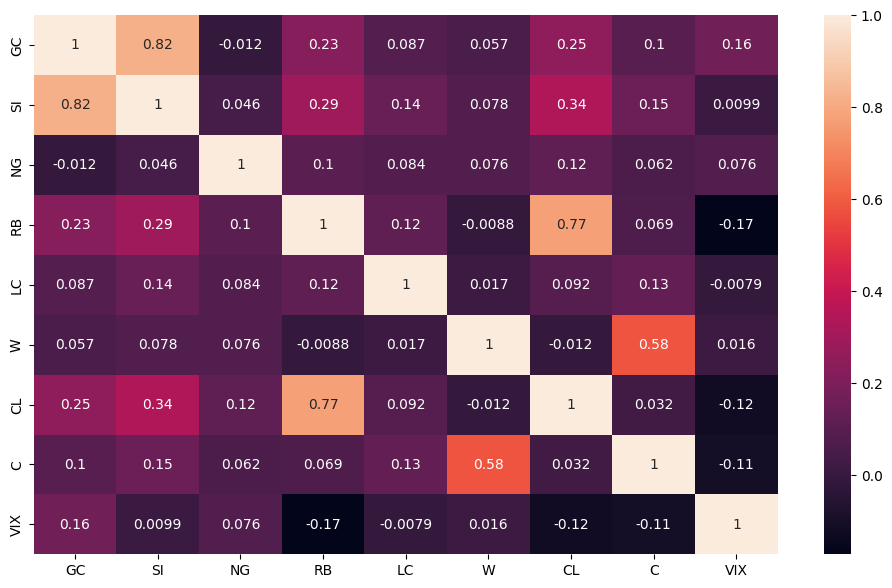

In [18]:
all_futures = pd.concat([futures,vix_data.loc[START_DATE:END_DATE].pct_change().dropna()],axis=1)
plt.subplots(figsize=(12,7))
sns.heatmap(all_futures.corr(),annot=True)

For the trading strategy, we elect to use CL and SI. These choices were made in unison with the results from the paper as well as the correlations seen in 2014. From the paper, it is evident that CL and SI are both correlated to volatility in the markets. We saw that CL has a high magnitude in unconditional correlation to VIX returns. Our choice is in SI is done with primarily evidence from the paper and done to hopefully prevent overfitting. We see that GC and SI are highly correlated but SI has a low correlation to VIX compared to GC. The choice in SI can also prevent any overfitting that could be done with the small sample of 2014.

We will now look at the correlations of bonds with VIX.

In [19]:
bond20y_data = DataCollection2014.fetch_quandl('YC/USA20Y')
bond10y_data = DataCollection2014.fetch_quandl('YC/USA10Y')
bond5y_data = DataCollection2014.fetch_quandl('YC/USA5Y')
bond1y_data = DataCollection2014.fetch_quandl('YC/USA1Y')

<AxesSubplot: >

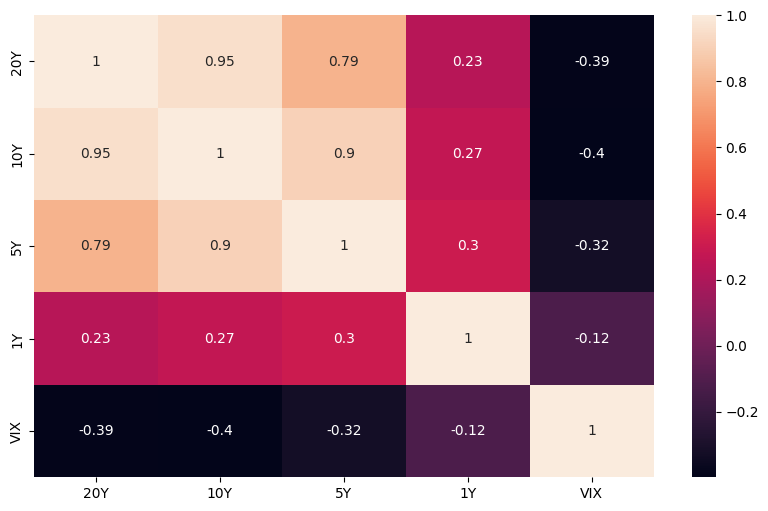

In [20]:
bond_data = pd.concat([bond20y_data,bond10y_data,bond5y_data,bond1y_data],axis=1)
bond_data.columns = ['20Y','10Y','5Y','1Y']
bond_data = bond_data.loc[bond_data.index.isin(vix_data.loc[START_DATE:END_DATE].index)]
bond_data = bond_data.pct_change().dropna()
bond_data = pd.concat([bond_data,vix_data.loc[START_DATE:END_DATE].pct_change().dropna()],axis=1)

plt.subplots(figsize=(10,6))
sns.heatmap(bond_data.corr(),annot=True)

We see that the correlation between bond yields and VIX is generally negative, with the correlation increasing as the duration increases. Thus, when we expect high VIX returns, we would expect rising bond prices as yield is inversely correlated to bond prices. As a substitute to calculating bond prices, we will use a bond ETF. Here, we select TLT.

To summarize, we will use 5 different assets for our trading strategy: TLT (bond ETF), CL (crude oil future), SI (silver future). The last 2 assets will be with SPY ETF and the correspond vanilla SPY option. As mentioned earlier, SPY options can increase in value if the implied volatility (or vega) increases. By buying vanilla SPY calls and shorting SPY ETF to remain delta neutral, we can be inpervious to the directional changes in the market and be primarily exposed to vega (though there is some gamma risk).

The options data was retrieved from WRDS. Due to the file size, the entire chain is not provided (though a small subset for a day is provided). To access the entirety, you will need to first generate signals with the `TradingStrategy` class before using the *obtain_chain()* function. 

In [21]:
# options_chain = pd.read_csv('options_chain.csv',index_col=0,parse_dates=True)
options_chain = pd.read_csv('/Users/tmac/Downloads/options_chain (2).csv',index_col=0,parse_dates=True)

TradingStrategy = trading_strategy.TradingStrategy(Model.predicted_results,0,spy_data,vix_data,conn,options_chain)
TradingStrategy.signals = pd.read_csv('/Users/tmac/Downloads/signals.csv')
TradingStrategy.signals = TradingStrategy.signals.rename(columns = {'Unnamed: 0': 'date'})
TradingStrategy.signals['date'] = pd.to_datetime(TradingStrategy.signals['date'])
TradingStrategy.signals = TradingStrategy.signals.set_index('date')

# TradingStrategy.create_signals()
# TradingStrategy.signals.to_csv('signals.csv')

In [22]:
tlt_data = pd.read_csv('./data/tlt_data.csv',index_col=0,parse_dates=True)
cl_data = pd.read_csv('./data/cl_data.csv',index_col=0,parse_dates=True)
si_data = pd.read_csv('./data/si_data.csv',index_col=0,parse_dates=True)

With the assets being established, it is now a good time to mention position sizing. We have 5 assets, though 1 asset directly depends on another (the number of short SPY ETF directly depends on total delta of the call options). However, the 4 other assets are essentially independent of each other and as a result, we will give them equal maximum allocation. In other words, the maximum capital that we can allocate to each asset is the same. For example, if this amount is $100,000, we can allocate a maximum of $100,000 to these 4 different assets.

However, we will not always allocate \$100,000 to these assets. For our futures (SI and CL) and bond ETF (TLT), we are in a sense, betting on the direction of these assets as a proxy of VIX. Since these assets have correlation to VIX, it would make sense to allocate our position size based on rolling historical correlation. If we expect these assets to have high correlation (in magnitude) to VIX, we would allocate more capital. To do this, we take the rolling 30-day correlation of the returns of these assets and VIX returns and set our position size to be $ \text{corr(VIX, asset)} * 100000 $. For the option component of the strategy, we will always use all \$100,000 in capital. The SPY option component is always delta hedged so the direction does not matter. As a result, it is fine to be fully allocated in options with the entire capital size.

It is also important to mention the leverage requirements. Futures are a leveraged product and as a result, require some margin that is always met (in order to not be margin called). Here, we will consider the margin to be two times the maintenance margin. This, along with the fact taht correlations will never be more than 0.5 between the asset and VIX should ensure proper risk measures. For the bond ETF, we will assume a 2x leverage ratio. In other words, if we buy 200 shares of TLT, we can borrow another 200 shares. For simplicity, we will assume our position size to be twice our position size calculated by the formula above. Since our correlations will never be too big for our assets, we can assume that this will be enough margin to avoid any margin calls. Furthermore, we can assume that we will be able to short $\Delta$ shares of SPY such that we are delta-neutral to the general market direction.

In terms of entry and exit, we will enter when the prediction is above or below a threshold. If the prediction is above the rolling threshold (mentioned above), we will enter a long position. This long position will consist of shorting CL, buying SI, buying TLT, buying SPY calls, and shorting SPY ETF. If the prediction is below the rolling threshold, we will take the opposite position. Our exit will always be one day later since our forecast is a 1-day forecast. There is no point remaining in the position for a longer time and as a result, there are no "stop losses" due to this fact. The short times in positions should help remedy the high tail risk that is present in these strategies, especially when trying to short VIX (you make money as VIX decays until an unexpected event occurs, where you lose everything).

We assume that we can buy everything at the close. We will use total position sizes of maximum dollar size $100,000 with the methodology mentioned above. We will assume that there is enough liquidity so that we can purchase our orders at these prices. In reality, there may be some slippage. For options, we only consider the options that has the second nearest expiration date as these are the most liquid. We will always purchase these options at the at-the-money strike. We will give more details for each asset as we go through them. 

We will now go through each asset, assuming a maximum of $100,000 with specifications mentioned above. We will first leave out transaction costs and later include them in the following section. 

In [23]:
positions = TradingStrategy.position_sizing(si_data,30)
si = TradingStrategy.backtest(si_data,-1,positions,100_000,16000,5000,mode='future', transaction_fee=2.25)[['Daily PnL']]
positions = TradingStrategy.position_sizing(cl_data,30)
cl = TradingStrategy.backtest(cl_data,-1,positions,100_000,12000,1000,mode='future', transaction_fee=2.25)[['Daily PnL']]
positions = TradingStrategy.position_sizing(tlt_data,30)
tlt = TradingStrategy.backtest(tlt_data,1,positions,100_000,None,mode='equity', transaction_fee=.15)[['Daily PnL']]

Futures have quarterly expires and thus it is good to roll them over at an earlier point to avoid liquidity issues when exiting your position at a later time. We use the approach done in the homework.

In [24]:
options = TradingStrategy.backtest_options(100_000)
positions = options['Delta'].to_frame('Size')
spy = TradingStrategy.backtest(spy_data[['close']],-1,positions,100_000,None,mode='spy')[['Daily PnL']]

In [25]:
daily_pnls = pd.concat([si,cl,tlt,options['Daily PnL'],spy],axis=1)
daily_pnls.columns = ['SI','CL','TLT','SPY Calls','SPY ETF']

First, since the SPY calls and short SPY ETFs are unique. We will show specifically the delta hedge first. Let's look at the strictly the PnL.

In [26]:
delta_hedge_pnl = daily_pnls[['SPY Calls','SPY ETF']]
delta_hedge_pnl['Total'] = delta_hedge_pnl['SPY Calls'] + delta_hedge_pnl['SPY ETF']

In [27]:
TradingStrategy.plot_pnls(delta_hedge_pnl,0,'2015','2021',adj_h=500,adj_w=900)

We see that without transaction fees, we make a measly $500 in the 6 year period. Now, let's plot everything together.

In [28]:
TradingStrategy.plot_pnls(daily_pnls,0,'2015','2021',adj_h=500,adj_w=900)

This assumes a $100,000 initial capital for all assets. When we examine the portfolio, we do not include the $100,000 initial capital for the SPY ETF as we assume that our position in the other 4 assets is enough collateral to fund our SPY position.

In [29]:
TradingStrategy.performance_metrics((100_000+daily_pnls.cumsum()).pct_change().dropna())

,SI,CL,TLT,SPY Calls,SPY ETF
Annualized Return,0.044948,0.035585,0.020341,-0.053194,0.009073
Annualized Volatility,0.099833,0.190902,0.080349,0.026769,0.023771
Annualized Sharpe Ratio,0.450237,0.186406,0.253154,-1.987102,0.381686
Annualized Sortino Ratio,0.239491,0.090191,0.146289,-1.267192,0.195557
Skewness,8.532713,2.873571,7.451681,-0.104577,1.796501
Kurtosis,181.311982,163.636189,240.13251,33.070494,61.599563
VaR (0.05),-0.000022,-0.000062,-0.001244,-0.002704,-0.000002
CVaR (0.05),-0.006372,-0.016916,-0.005693,-0.005327,-0.00247


In [30]:
daily_pnls['Portfolio'] = daily_pnls.sum(axis=1)
portfolio_pnl = daily_pnls[['Portfolio']]
TradingStrategy.plot_pnls(portfolio_pnl,400000,'2015','2021',adj_h=500,adj_w=900)

In [31]:
TradingStrategy.performance_metrics((400000+portfolio_pnl.cumsum()).pct_change().dropna()).T

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
Portfolio,0.014304,0.072535,0.197202,0.104418,3.420714,145.761334,-0.001045,-0.006337


## To-do list

- Need to add more commentary in section 3
- Section labels
- Shorting & correct transaction fees (margin requirement verbiage)
- Analysis in section 4 (portfolio metrics i.e fee analysis / proportion of profit / yearly /etc)


for spy
- let's assume that we don't need to post anymore collateral to short ETF (the collateral we have with our SPY options and futures is enough to fund our SPY ETF short position)

i also changed TLT position to (1.5 * position_sizing func) * 2 so we actually be "leveraged" sometimes (we need good leverage assumptions)

i think for margin we try to set our margin as 2x what it is right now and say that it's a good assumption (can maybe even link to some evidence) with historical values

still need to add shorting rate for SPY ETFs then